# **CSI 4106 Introduction to Artificial Intelligence**
## **Assignment 4: Heuristic Search**

### Identification

Name: Joe Zhang <br/>
Student Number: 300245795

Name: Christian Paravalos <br/>
Student Number: 300231900

<br/>
<hr/>

## **Overview**

The **Traveling Salesman Problem (TSP)** is a classic optimization problem in computer science and operations research. Given a set of cities and the distances between them, the goal is to find the shortest possible route that visits each city exactly once and returns to the starting city. Despite its simple formulation, solving TSP is computationally challenging because the number of possible routes grows factorially with the number of cities.

TSP is classified as an NP-hard problem, meaning there is no known efficient algorithm to solve it optimally for large instances. This complexity, combined with its practical importance in fields like logistics, manufacturing, and circuit design, has made TSP a benchmark problem for evaluating optimization algorithms.

In this assignment, you will explore three different approaches to tackling TSP:

- **Greedy Algorithm**: A heuristic method that builds a solution incrementally by choosing locally optimal decisions.
- **Simulated Annealing (SA)**: A probabilistic algorithm inspired by the annealing process in metallurgy.
- **Genetic Algorithm (GA)**: An evolutionary algorithm that mimics natural selection to iteratively improve solutions.

The final deliverable for this assignment will be a Jupyter Notebook documenting your implementation, results, and observations for each approach.

## **Learning Objectives**

- **Explore** and **implement** different search-based algorithms.
- **Develop** a Simulated Annealing algorithm with an effective strategy for setting the initial temperature.
- **Adapt** and **apply** a Genetic Algorithm for solving the TSP.
- **Analyze** and **evaluate** the performance of each algorithm against known optimal solutions.

## Submission 

- **Deadline:**
   - Submit your notebook by December 4, 11 PM.
- **Individual or Group Assignment:**
   - This assignment may be undertaken either individually (group of 1 student) or collaboratively in pairs (group of 2 students)
   - A group must submit a single joint submission.
   - Prior to submitting, it is necessary to **register your group** on Brightspace.
- **Submission Platform:**
   - Upload your submission to Brightspace under the Assignment section (Assignment 4).
- **Submission Format:**
   - Submit a copy of your notebook on Brightspace.

**Important Notice:** If the corrector cannot run your code, your submission will receive a mark of zero. It is your responsibility to ensure that your submission works from a different computer than your own and that all cells in your notebook are executable.

## **Datasets**

The datasets utilized in this assignment are sourced from the [TSPLIB GitHub Repository](https://github.com/mastqe/tsplib), which provides standard benchmark instances for the Traveling Salesman Problem (TSP). These datasets are defined as **Euclidean**, meaning that the distance between any two cities is calculated using the Euclidean metric based on their coordinates.

For your tests, you will employ the **berlin52-24-4** and **st70-24** datasets. Each of these is a subset consisting of 24 cities from the respective problems. The lower bound on cost for these instances has been determined using dynamic programming, specifically the Held-Karp algorithm.

1. **berlin52-24-4**:
   - Number of Cities: 24
   - Optimal Solution Cost: **5890.92**

2. **st70-24-4**:
   - Number of Cities: 24
   - Optimal Solution Cost: **468.88**

These datasets are intended for evaluating the performance of your algorithms, enabling you to compare your results with established optimal solutions. The data is accessible on GitHub at the following link: [here](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a4). Additionally, the `extra` subfolder contains supplementary problems that may assist you in completing this assignment.

For the optional bonus question, you will work with the following two datasets:

3. **berlin52**:
   - Number of Cities: 52
   - Description: A medium-sized dataset with realistic spatial distribution of cities.
   - Optimal Solution Cost: **7542**

4. **st70**:
   - Number of Cities: 70
   - Description: A slightly larger dataset with increased complexity.
   - Optimal Solution Cost: **675**

<br>
<hr/>

## **0. Given Code**

Here is a Jupyter Notebook featuring greedy algorithms and a genetic algorithm for solving the 0/1 knapsack problem.

<a target="_blank" href="https://colab.research.google.com/github/turcotte/csi4106-f24/blob/main/notebooks/lectures/16/knapsack.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

The following two lectures may be useful for this assignment.

- [Lecture 15](https://turcotte.xyz/teaching/csi-4106/lectures/15/slides.html) (simulated annealing)
- [Lecture 16](https://turcotte.xyz/teaching/csi-4106/lectures/16/slides.html) (genetic algorithm)

### 0.1. Imports

In [2]:
# Imports needed for the assignment go here:

import numpy as np
import pandas as pd
import requests
import math
import time

### 0.2. Read the TSP Files

A function to read TSP files from a website.

In [3]:
def read_tsp(url):

    """
    Reads a .tsp file from a given URL and returns a NumPy array of coordinates.

    Parameters:
    -----------
    url : str
        The URL of the .tsp file.

    Returns:
    --------
    coordinates : ndarray
        A NumPy array of coordinates extracted from the .tsp file.

    Description:
    ------------
    This function fetches the content of a .tsp file from a specified URL and parses it to extract the city coordinates.
    It looks for the 'NODE_COORD_SECTION' in the file to start reading coordinates and stops when it reaches 'EOF'.
    The function handles potential errors by checking the HTTP response status and ensures that the coordinates are
    correctly parsed into floating-point numbers.

    Example:
    --------
    >>> url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/berlin52-24-4.tsp'
    >>> coordinates = read_tsp(url)
    >>> print(coordinates)
    [[37.7692, -122.4443],
     [37.7689, -122.4240],
     ...
     [37.7793, -122.4192]]
    """

    try:
        # Fetch the content from the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

        # Split the content into lines
        lines = response.text.splitlines()

        # Initialize a list to store the coordinates
        coordinates = []

        # Start reading after the NODE_COORD_SECTION line
        node_section = False
        for line in lines:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                node_section = True
                continue
            elif line == "EOF":
                break

            if node_section:
                # Split the line into parts and convert to float
                parts = line.split()
                if len(parts) >= 3:
                    # Some files include node indices, so we take the last two entries as coordinates
                    x, y = float(parts[-2]), float(parts[-1])
                    coordinates.append((x, y))

        # Convert the list of coordinates to a NumPy array
        return np.array(coordinates)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the TSP file: {e}")
        return None
    except ValueError as e:
        print(f"An error occurred while parsing the coordinates: {e}")
        return None

In [4]:
URL = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/'

berlin52_24_4 = read_tsp(URL + 'berlin52-24-4.tsp')
st70_24_4 = read_tsp(URL + 'st70-24-4.tsp')

The following function accepts the coordinates of the cities as input and outputs a distance matrix.

In [5]:
def get_distance_matrix(coordinates):

    """
        Takes coordinates input and returns distance matrix
        Input: coordinates (nn.array) - the input coordinates
        Output: distance_matrix (np.array) - the (num_cities x num_cities) distance matrix
    """

    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])
            
    return distance_matrix 

The following functions may assist in visualizing results and debugging your programs.

In [6]:
import matplotlib.pyplot as plt

def plot_cities(coordinates, title="Cities in the Traveling Salesman Problem"):

    """
    Plots the given coordinates representing cities.
    
    Parameters:
    - coordinates: A 2D NumPy array of shape (n, 2) representing the (x, y) coordinates.
    - title: Title for the plot.
    """

    # Extract x and y coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # Plot the cities as red dots
    plt.scatter(x, y, c='red', zorder=2)

    # Annotate the cities with their indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Set title and labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.axis('equal')  # Equal scaling for x and y axes
    plt.show()

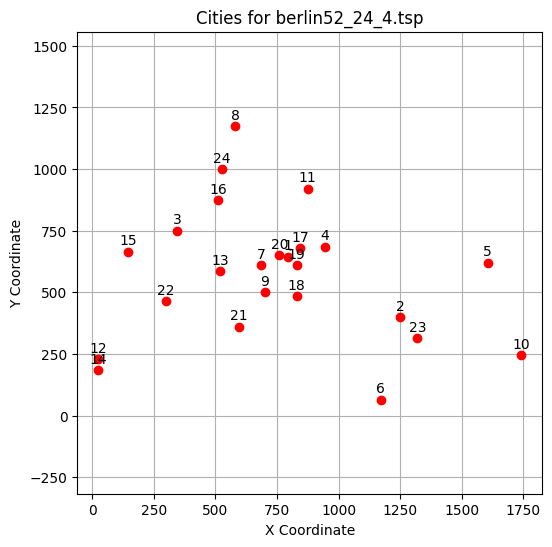

In [7]:
plot_cities(berlin52_24_4, title='Cities for berlin52_24_4.tsp')

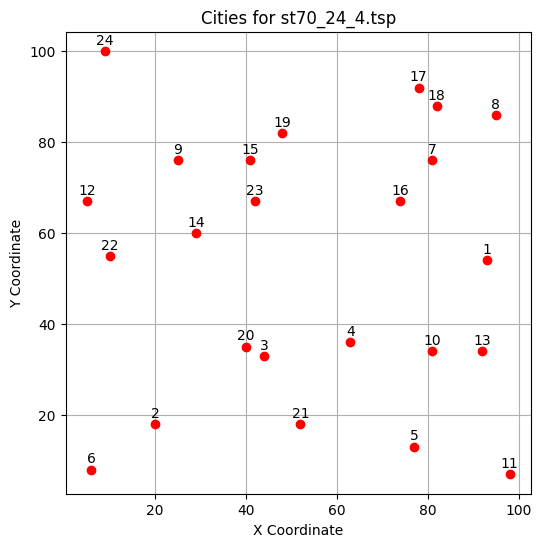

In [8]:
plot_cities(st70_24_4, title='Cities for st70_24_4.tsp')

In [9]:
def plot_tsp_path(coordinates, path=None, title="Traveling Salesman Problem"):

    """
    Plots the given coordinates and optionally a path for the TSP.
    
    Parameters:
    - coordinates: A 2D NumPy array of shape (n, 2) representing the (x, y) coordinates.
    - path: A list or array of indices representing the order of visiting the nodes. If None, nodes are connected in input order.
    - title: Title for the plot.
    """

    # Extract x and y coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # If a path is given, reorder the coordinates
    if path is not None:
        x = x[path]
        y = y[path]
    
    # Plot the nodes
    plt.scatter(x, y, c='red', zorder=2)

    # Annotate the nodes with their indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Plot the path
    plt.plot(x, y, 'b-', zorder=1)

    # If a path is provided, connect the last point to the first to complete the tour
    if path is not None:
        plt.plot([x[-1], x[0]], [y[-1], y[0]], 'b-', zorder=1)

    # Set title and labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.axis('equal')  # Equal scaling for x and y axes
    plt.show()

<hr/>

## 1. Implement the Algorithms

### 1.1. Implement a solver for the TSP using Greedy Algorithm

The **nearest neighbor heuristic** is a greedy algorithm used to find a feasible solution to the Traveling Salesman Problem (TSP). 
- The process begins by selecting a starting city and iteratively visiting the nearest unvisited city until all cities are visited. The tour is completed by returning to the starting point. 
- This procedure is repeated for each city as the initial starting point, and the shortest resulting tour is selected. 
- The algorithm strictly evaluates only valid routes, ensuring each city is visited exactly once. 
- While this approach efficiently constructs a feasible TSP solution, it does not ensure an optimal solution.

In [10]:
def greedy_tsp(distance_matrix):

    num_cities = len(distance_matrix)

    best_route = None

    best_distance = np.inf

    for start_city in range(num_cities):
        unvisited = set(range(num_cities))

        current_city = start_city

        route = [current_city]

        total_distance = 0
        best_route = route

        # Continue until all cities are visited
        while unvisited:

            # Select the nearest unvisited city
            min_distance = np.inf
            nearest_city = None

            for city in unvisited:
                    distance = distance_matrix[current_city][city]
                    if distance < min_distance:
                        min_distance = distance
                        nearest_city = city

            unvisited.remove(nearest_city)

            route.append(nearest_city)

            total_distance += distance_matrix[current_city, nearest_city]

            current_city = nearest_city

        # Return to the starting city
        total_distance += distance_matrix[current_city, start_city]

        if total_distance < best_distance:
            best_distance = total_distance
            best_route = route

    print(f'Best Route: {best_route}')
    print(f'Best Distance: {best_distance}')

    return best_route, best_distance

berlin52_24_4_distance_matrix = get_distance_matrix(berlin52_24_4)
st70_24_4_distance_matrix = get_distance_matrix(st70_24_4)

greedy_tsp(berlin52_24_4_distance_matrix)
greedy_tsp(st70_24_4_distance_matrix)


Best Route: [23, 23, 15, 2, 14, 21, 12, 6, 19, 0, 18, 16, 3, 17, 8, 20, 11, 13, 10, 7, 1, 22, 5, 9, 4]
Best Distance: 7029.605933260265
Best Route: [23, 23, 8, 14, 22, 13, 21, 11, 18, 15, 6, 17, 16, 7, 0, 12, 9, 3, 2, 19, 20, 4, 10, 1, 5]
Best Distance: 565.4375142594132


([23,
  23,
  8,
  14,
  22,
  13,
  21,
  11,
  18,
  15,
  6,
  17,
  16,
  7,
  0,
  12,
  9,
  3,
  2,
  19,
  20,
  4,
  10,
  1,
  5],
 np.float64(565.4375142594132))

### 1.2. Implement a solver for the TSP using Simulated Annealing

For the implementation of Simulated Annealing (SA) algorithm below, **implement a strategy to determine the initial temperature for the search**.

**Suggestions**:
- Calculate the cost of a random tour and set an initial temperature such that the acceptance rate of new solutions is between 60% and 80%.
- Alternatively, perform a few preliminary iterations of the SA algorithm, gradually reducing the temperature until the acceptance rate achieves the desired range of 60% to 80%. Then, restart with this temperature.

Specifically, you need to finalize the implementation of the `get_initial_temperature` method below.

In [11]:
def calculate_total_distance(route, distance_matrix):

    """
    Calculate the total distance of a given route based on the distance matrix.

    Parameters:
    -----------
    route : ndarray
        An array representing the order of cities in the route (a permutation of city indices).
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    total_distance : float
        The total distance of the route, including the return to the starting city.

    Description:
    ------------
    The function computes the sum of distances between consecutive cities in the route
    and adds the distance from the last city back to the first city to complete the tour.
    It assumes that the distance matrix is symmetric and non-negative.
    """
    
    total_distance = 0

    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i], route[i + 1]]

    total_distance += distance_matrix[route[-1], route[0]]  # Back to start

    return total_distance

In [12]:
def get_neighbor(route):

    """
    Generate a neighboring solution by reversing a random segment of the route.

    Parameters:
    -----------
    route : ndarray
        An array representing the current route (a permutation of city indices).

    Returns:
    --------
    new_route : ndarray
        A new route obtained by reversing the segment between two randomly chosen indices.

    Description:
    ------------
    This method selects two random indices, `a` and `b`, within the route and reverses the
    segment between them (inclusive). It is commonly used in optimization algorithms like 
    Simulated Annealing to explore neighboring solutions in the search space.
    """

    a, b = np.random.randint(0, len(route), size=2)

    if a > b:
        a, b = b, a

    new_route = route.copy()
    new_route[a:b+1] = new_route[a:b+1][::-1]  # Reverse the segment between a and b
    
    return new_route

Finalize the implementation of the `get_initial_temperature` method. You may introduce additional parameters to the function definition as needed; ensure that any modifications are consistently reflected in all methods that invoke this function.

In [33]:
def get_initial_temperature(distance_matrix):

    """
    Estimate an initial temperature for the Simulated Annealing algorithm.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    initial_temp : float
        The estimated initial temperature to achieve the specified acceptance rate.

    Description:
    ------------
    The function:
        - Complete this section
    """

    initial_temp = 0
    counter = 0

    # Code goes here
    for i in range(1000):
        num_cities = len(distance_matrix)
        current_route = np.arange(num_cities)
        np.random.shuffle(current_route)
        current_cost = calculate_total_distance(current_route, distance_matrix)

        neighbor_route = get_neighbor(current_route)
        neighbor_cost = calculate_total_distance(neighbor_route, distance_matrix)

        if current_cost < neighbor_cost:
            initial_temp += -(neighbor_cost - current_cost)/np.log(0.8)
            counter+=1

    initial_temp = initial_temp/counter

    return initial_temp

In [14]:
def simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations):

    """
    Perform the Simulated Annealing algorithm to approximate a solution for the Traveling Salesman Problem (TSP).

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    initial_temp : float
        The initial temperature for the annealing process.
    cooling_rate : float
        The rate at which the temperature decreases, typically a value between 0 and 1.
    max_iterations : int
        The maximum number of iterations to perform.

    Returns:
    --------
    best_route : ndarray
        The order of cities in the best (shortest) route found.
    best_cost : float
        The total distance of the best route.
    temperatures : list
        A list of temperature values at each iteration, useful for analysis or plotting.
    costs : list
        A list of route costs (distances) at each iteration, useful for analysis or plotting.

    Description:
    ------------
    Simulated Annealing (SA) is a probabilistic optimization algorithm inspired by the annealing process in metallurgy. 
    This implementation:
    - Starts with a random route and iteratively improves it.
    - Accepts worse solutions with a probability dependent on the temperature to escape local minima.
    - Reduces the temperature gradually to focus on exploitation as the algorithm progresses.
    - Returns the best route found along with intermediate data for analysis.

    """

    num_cities = len(distance_matrix)
    current_route = np.arange(num_cities)
    np.random.shuffle(current_route)
    current_cost = calculate_total_distance(current_route, distance_matrix)
    
    best_route = current_route.copy()
    best_cost = current_cost

    temperatures = []
    costs = []

    temperature = initial_temp

    # Collect intermediate solutions
    intermediate_solutions = []
    
    for iteration in range(max_iterations):

        neighbor_route = get_neighbor(current_route)
        neighbor_cost = calculate_total_distance(neighbor_route, distance_matrix)
        
        # Accept neighbor if it's better, or with a probability if it's worse
        if neighbor_cost < current_cost or np.random.rand() < np.exp(-(neighbor_cost - current_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_route = current_route.copy()
                best_cost = current_cost

        # Store temperature and cost for plotting
        temperatures.append(temperature)
        costs.append(current_cost)

        # Cool down the temperature
        temperature *= cooling_rate

    return best_route, best_cost, temperatures, costs

In [15]:
def simulated_annealing_do_n(distance_matrix, initial_temp, cooling_rate=0.995, max_iterations=1000, repeats=20):

    """
    Perform Simulated Annealing multiple times and return the best result across all runs.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    initial_temp : float
        The initial temperature for the annealing process.
    cooling_rate : float
        The rate at which the temperature decreases, typically a value between 0 and 1.
    max_iterations : int
        The maximum number of iterations for each Simulated Annealing run.
    repeats : int
        The number of times to repeat the Simulated Annealing process.

    Returns:
    --------
    best_tour : ndarray
        The order of cities in the best (shortest) tour found across all runs.
    best_distance : float
        The total distance of the best tour.
    best_temperatures : list
        A list of temperature values from the best run, useful for analysis or plotting.
    best_costs : list
        A list of route costs (distances) from the best run, useful for analysis or plotting.

    Notes:
    ------
    This method leverages the `simulated_annealing` function to perform individual optimization runs. 
    By repeating the process multiple times, it increases the likelihood of finding a globally optimal or near-optimal solution.
    """

    results = [
        simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations)
        for _ in range(repeats)
    ]

    # Find the best result by minimizing the distance
    best_tour, best_distance, best_temperatures, best_costs = min(results, key=lambda x: x[1])

    return best_tour, best_distance, best_temperatures, best_costs

The following functions may assist in visualizing results and debugging your programs.

In [16]:
def plot_temperature_and_cost(temperatures, costs):

    """
    Plot the temperature and cost values over iterations in a side-by-side graph.

    Parameters:
    -----------
    temperatures : list or ndarray
        A sequence of temperature values recorded at each iteration of an algorithm (e.g., Simulated Annealing).
    costs : list or ndarray
        A sequence of cost values (e.g., total distance or energy) recorded at each iteration.

    Description:
    ------------
    This function generates two subplots:
    1. **Temperature Over Iterations**: Plots how the temperature changes over time, which is useful for visualizing the cooling schedule in algorithms like Simulated Annealing.
    2. **Cost Over Iterations**: Plots the cost (e.g., total distance in TSP) at each iteration, showing how the solution improves over time.

    The plots are arranged side by side for easy comparison between the temperature schedule and the corresponding cost progression. The function adjusts the layout for better spacing and displays the combined figure.

    Example:
    --------
    >>> plot_temperature_and_cost(temperatures, costs)

    Notes:
    ------
    - Ensure that the lengths of `temperatures` and `costs` are equal, corresponding to the number of iterations.
    - Requires `matplotlib.pyplot` as `plt` to be imported before calling this function.
    """
    
    # Plot temperature and cost graphs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(temperatures)
    plt.title("Temperature Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Temperature")

    plt.subplot(1, 2, 2)
    plt.plot(costs)
    plt.title("Cost Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")

    plt.tight_layout()
    plt.show()

### 1.3. Implement a solver for the TSP using Genetic Algorithm

You will find below a partial implementation of a **Genetic Algorithm (GA)** to find an approximate solution to the TSP.

The main steps of the algorithm are:

1. **Initialization**: Create a random initial population of routes.
2. **Evaluation**: Compute the fitness of individuals based on their route distances. (partial implementation)
3. **Elitism**: Preserve the top-performing individuals for the next generation.
4. **Selection**: Choose parents using tournament or roulette wheel selection.
5. **Crossover**: Generate offspring by combining parents using a crossover operator. (partial implementation)
6. **Mutation**: Introduce diversity by randomly mutating offspring. (partial implementation)
7. **Replacement**: Combine elites and offspring to form the next generation.
8. Repeat steps 2-7 for a fixed number of generations, tracking the best and average distances.

Ensure that all generated solutions are valid tours, with each city visited exactly once.

Specifically, you must implement `evaluate_fitness`, `crossover_operator`, `mutation`.

In [17]:
def initialize_population(pop_size, num_cities):

    """
    Generate an initial population of random routes for a Genetic Algorithm.

    Parameters:
    -----------
    pop_size : int
        The number of individuals (routes) in the population.
    num_cities : int
        The number of cities in the Traveling Salesman Problem (TSP).

    Returns:
    --------
    population : ndarray
        A 2D array of shape (pop_size, num_cities), where each row represents
        a random permutation of city indices (a potential solution).

    Description:
    ------------
    This function initializes a population by creating `pop_size` random permutations
    of city indices, ensuring diversity in the initial solutions. Each individual
    represents a valid route for the TSP.
    """
    
    return np.array([np.random.permutation(num_cities) for _ in range(pop_size)])

Finalize the implementation of the `evaluate_fitness` method.

In [18]:
def evaluate_fitness(population, distance_matrix):

    """
    Evaluate the fitness of each individual in a population for a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row is an individual route (a permutation of city indices).
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.

    Returns:
    --------
    fitness : ndarray
        A 1D array containing the fitness values for each individual in the population.
        Fitness is calculated as the reciprocal of the total distance of the route.
    total_distances : ndarray
        A 1D array containing the total distances of the routes for each individual.

    Description:
    ------------
    This function calculates:
    1. The total distance of each individual's route by summing the distances between consecutive cities,
       including the return to the starting city.
    2. The fitness value for each individual as the reciprocal of its total distance
       (with a small constant added to avoid division by zero).

    Fitness values are higher for shorter routes, encouraging better solutions during selection.
    """

    # Code goes here   
    
    return fitness, total_distances

In [19]:
def tournament_selection(population, fitness, tournament_size):

    """
    Perform tournament selection to choose individuals for the next generation in a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual (a potential solution).
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.
    tournament_size : int
        The number of individuals randomly selected for each tournament.

    Returns:
    --------
    selected_population : ndarray
        A 2D array of the same shape as `population`, containing the selected individuals
        for the next generation.

    Description:
    ------------
    Tournament selection works as follows:
    1. For each individual to be selected, randomly choose `tournament_size` participants from the population.
    2. Compare their fitness values and select the individual with the highest fitness.
    3. Repeat this process until a new population of the same size as the original is formed.

    This method balances exploitation (choosing the best individuals) with exploration (random selection
    of participants), allowing the algorithm to focus on high-quality solutions while maintaining diversity.
    """

    pop_size = population.shape[0]
    selected_indices = []
    
    for _ in range(pop_size):

        participants = np.random.choice(pop_size, tournament_size, replace=False)
        best = participants[np.argmax(fitness[participants])]
        selected_indices.append(best)

    return population[selected_indices]

In [20]:
def roulette_selection(population, fitness):

    """
    Perform roulette wheel selection to choose individuals for the next generation in a Genetic Algorithm.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual (a potential solution).
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.

    Returns:
    --------
    selected_population : ndarray
        A 2D array of the same shape as `population`, containing the selected individuals
        for the next generation.

    Description:
    ------------
    Roulette wheel selection assigns selection probabilities to individuals based on their fitness:
    1. Compute the total fitness of the population.
    2. Normalize fitness values to create probabilities for each individual.
    3. Randomly select individuals from the population according to their probabilities.

    This method favors individuals with higher fitness, increasing their likelihood of being selected,
    while still allowing lower-fitness individuals a chance, maintaining genetic diversity.
    """

    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    pop_size = population.shape[0]
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities)
    
    return population[selected_indices]

Finalize the implementation of the `crossover_operator` method.

In [21]:
def crossover_operator(parent1, parent2):

    """
    Perform crossover to produce an offspring from two parent solutions.

    Parameters:
    -----------
    parent1 : ndarray
        A 1D array representing the first parent (a permutation of city indices).
    parent2 : ndarray
        A 1D array representing the second parent (a permutation of city indices).

    Returns:
    --------
    child : ndarray
        A 1D array representing the offspring, combining genetic material from both parents.

    Description:
    ------------
        Complete the description.
    """

    # Code goes here

    return child    

In [22]:
def crossover(parents, crossover_rate):

    """
    Perform crossover on a population of parent solutions to produce offspring for the next generation.

    Parameters:
    -----------
    parents : ndarray
        A 2D array where each row represents a parent solution (a permutation of city indices).
    crossover_rate : float
        The probability of applying crossover to a pair of parents (value between 0 and 1).

    Returns:
    --------
    offspring : ndarray
        A 2D array of the same shape as `parents`, containing the offspring produced by crossover.

    Description:
    ------------
    This function generates offspring by pairing parents and applying a crossover operator:
    1. Randomly shuffle the parents to create random pairs.
    2. For each pair of parents, apply crossover with a probability defined by `crossover_rate`.
       - If crossover occurs, use `crossover_operator` to produce two children.
       - If not, directly copy the parents as the children.
    3. Continue until all parents are processed, ensuring the offspring population size matches the original.

    This approach maintains diversity while combining genetic material from pairs of parents to explore the search space.
    """

    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []

    for i in range(0, num_parents, 2):

        parent1 = parents[i]
        parent2 = parents[i + 1 if i + 1 < num_parents else 0]

        if np.random.rand() < crossover_rate:
            child1 = crossover_operator(parent1, parent2)
            child2 = crossover_operator(parent2, parent1)
        else:
            child1 = parent1.copy()
            child2 = parent2.copy()

        offspring.append(child1)
        offspring.append(child2)

    return np.array(offspring)

Finalize the implementation of the `mutation` method.

In [23]:

def mutation(offspring, mutation_rate):

    """
    Apply mutation to a population of offspring.

    Parameters:
    -----------
    offspring : ndarray
        A 2D array where each row represents an offspring solution (a permutation of city indices).
    mutation_rate : float
        The probability of applying mutation to each offspring (value between 0 and 1).

    Returns:
    --------
    offspring : ndarray
        A 2D array of the same shape as the input, with mutations applied to some individuals.

    Description:
    ------------
        Complete the description.
    """

    # Code goes here

    return offspring

In [24]:
def elitism(population, fitness, elite_size):

    """
    Retain the top-performing individuals in a population based on their fitness.

    Parameters:
    -----------
    population : ndarray
        A 2D array where each row represents an individual solution.
    fitness : ndarray
        A 1D array containing the fitness values of the individuals in the population.
    elite_size : int
        The number of top-performing individuals to retain.

    Returns:
    --------
    elite_population : ndarray
        A 2D array containing the `elite_size` individuals with the highest fitness.

    Description:
    ------------
    This function implements elitism, which ensures that the best solutions are carried
    over to the next generation without modification:
    1. Sort the individuals in the population by their fitness values.
    2. Select the indices of the top `elite_size` individuals.
    3. Return the corresponding elite individuals from the population.

    Elitism helps preserve high-quality solutions, improving the stability and convergence
    of a Genetic Algorithm.
    """

    elite_indices = np.argsort(fitness)[-elite_size:]

    return population[elite_indices]

In [25]:
def genetic_algorithm(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3):

    """
    Solve the Traveling Salesman Problem (TSP) using a Genetic Algorithm (GA).

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    pop_size : int, optional
        The size of the population (default: 100).
    num_generations : int, optional
        The number of generations to evolve (default: 200).
    crossover_rate : float, optional
        The probability of applying crossover to a pair of parents (default: 0.8).
    mutation_rate : float, optional
        The probability of mutating an offspring (default: 0.05).
    elite_percent : float, optional
        The fraction of the population to preserve as elites (default: 0.02).
    selection_type : str, optional
        The selection method to use ('tournament' or 'roulette', default: 'tournament').
    tournament_size : int, optional
        The number of participants in each tournament (used only for tournament selection, default: 3).

    Returns:
    --------
    best_solution : ndarray
        The order of cities in the best route found.
    best_distance : float
        The total distance of the best route.
    average_distance_history : list
        The average total distance of the population at each generation.
    best_distance_history : list
        The best total distance in the population at each generation.

    Description:
    ------------
    This function implements a Genetic Algorithm (GA) to find an approximate solution to the TSP:
    1. **Initialization**: Create a random initial population of routes.
    2. **Evaluation**: Compute the fitness of individuals based on their route distances.
    3. **Elitism**: Preserve the top-performing individuals for the next generation.
    4. **Selection**: Choose parents using tournament or roulette wheel selection.
    5. **Crossover**: Generate offspring by combining parents using a crossover operator.
    6. **Mutation**: Introduce diversity by randomly mutating offspring.
    7. **Replacement**: Combine elites and offspring to form the next generation.
    8. Repeat steps 2-7 for a fixed number of generations, tracking the best and average distances.

    At the end of the evolution process, the function returns the best solution found, along with metrics
    for performance analysis over generations.

    Notes:
    ------
    - The algorithm ensures the population size remains constant across generations.
    - `selection_type` determines the strategy used for selecting parents (tournament is the default).
    - The function can be customized further with different crossover and mutation operators.
    """

    num_cities = distance_matrix.shape[0]
    elite_size = max(1, int(pop_size * elite_percent))
    population = initialize_population(pop_size, num_cities)
    
    average_distance_history = []
    best_distance_history = []
    
    for generation in range(num_generations):

        fitness, total_distances = evaluate_fitness(population, distance_matrix)
        
        # Track average and best distances
        average_distance = np.mean(total_distances)
        best_distance = np.min(total_distances)
        average_distance_history.append(average_distance)
        best_distance_history.append(best_distance)

        # Elitism
        elites = elitism(population, fitness, elite_size)

        # Selection
        if selection_type == 'tournament':
            parents = tournament_selection(population, fitness, tournament_size)
        elif selection_type == 'roulette':
            parents = roulette_selection(population, fitness)
        else:
            raise ValueError("Invalid selection type")

        # Crossover
        offspring = crossover(parents, crossover_rate)

        # Mutation
        offspring = mutation(offspring, mutation_rate)

        # Create new population
        population = np.vstack((elites, offspring))

        # Ensure population size
        if population.shape[0] > pop_size:
            population = population[:pop_size]
        elif population.shape[0] < pop_size:
            num_new_individuals = pop_size - population.shape[0]
            new_individuals = initialize_population(num_new_individuals, num_cities)
            population = np.vstack((population, new_individuals))

    # Final evaluation to return the best solution
    fitness, total_distances = evaluate_fitness(population, distance_matrix)
    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    best_distance = total_distances[best_index]

    return best_solution, best_distance, average_distance_history, best_distance_history

In [26]:
def genetic_algorithm_do_n(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                           mutation_rate=0.05, elite_percent=0.02, selection_type='tournament',
                           tournament_size=3, repeats=20):

    """
    Run the Genetic Algorithm multiple times and return the best solution across all runs.

    Parameters:
    -----------
    distance_matrix : ndarray
        A square matrix where entry (i, j) represents the distance between city i and city j.
    pop_size : int, optional
        The size of the population (default: 100).
    num_generations : int, optional
        The number of generations to evolve in each run (default: 200).
    crossover_rate : float, optional
        The probability of applying crossover to a pair of parents (default: 0.8).
    mutation_rate : float, optional
        The probability of mutating an offspring (default: 0.05).
    elite_percent : float, optional
        The fraction of the population to preserve as elites (default: 0.02).
    selection_type : str, optional
        The selection method to use ('tournament' or 'roulette', default: 'tournament').
    tournament_size : int, optional
        The number of participants in each tournament (used only for tournament selection, default: 3).
    repeats : int, optional
        The number of times to repeat the Genetic Algorithm (default: 20).

    Returns:
    --------
    best_tour : ndarray
        The order of cities in the best route found across all runs.
    best_distance : float
        The total distance of the best route across all runs.
    best_averages : list
        The average total distances of the population at each generation for the best run.
    best_bests : list
        The best total distances at each generation for the best run.

    Description:
    ------------
    This function runs the Genetic Algorithm multiple times to improve the chances of finding a globally
    optimal solution. For each run, the results are compared, and the best route and corresponding metrics
    are retained. This approach leverages the stochastic nature of Genetic Algorithms to explore the solution
    space more thoroughly.
    """

    results = [
        genetic_algorithm(distance_matrix, pop_size, num_generations, crossover_rate,
                          mutation_rate, elite_percent, selection_type, tournament_size)
        for _ in range(repeats)
    ]
    
    best_tour, distance, averages, bests = min(results, key=lambda x: x[1])  # Minimize by total distance

    return best_tour, distance, averages, bests


The following function may assist in visualizing results and debugging your programs.

In [27]:
def plot_fitness_over_generations(avg_distances, best_distances):

    """
    Plot the average and best distances over generations in a Genetic Algorithm.

    Parameters:
    -----------
    avg_distances : list or ndarray
        A sequence of average distances of the population at each generation.
    best_distances : list or ndarray
        A sequence of the best (minimum) distances found at each generation.

    Description:
    ------------
    This function generates a line plot to visualize how the average and best distances
    evolve over the generations during the execution of a Genetic Algorithm. It helps in
    understanding the convergence behavior and effectiveness of the algorithm.

    - **X-axis**: Represents the generation number.
    - **Y-axis**: Represents the distance (cost) values.
    - **Curves**:
        - *Average Distance*: Shows the average performance of the population at each generation.
        - *Best Distance*: Highlights the best solution found up to that generation.

    Example:
    --------
    >>> plot_fitness_over_generations(average_distance_history, best_distance_history)

    Notes:
    ------
    - Ensure that `avg_distances` and `best_distances` are of the same length, corresponding to the number of generations.
    - Requires `matplotlib.pyplot` as `plt` to be imported before calling this function.
    - Call `plt.show()` if the plot does not display automatically in your environment.
    """
    
    # Plot the fitness over generations
    generations = range(1, len(avg_distances) + 1)
    plt.figure(figsize=(6, 6))

    # Plot average and best distances over generations
    plt.plot(generations, avg_distances, label='Average Distance')
    plt.plot(generations, best_distances, label='Best Distance')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.title('Distance Over Generations')
    plt.legend()
    plt.show()

<hr/>

## 2. Experimentation

### 2.1. Execute Each Algorithm on Both Datasets

- Run the **Greedy Algorithm**, **Simulated Annealing**, and **Genetic Algorithm** on the `berlin52_24_4` and `st70_24_4` datasets separately.
- Perform at least **10 independent runs** of each algorithm on each dataset to capture variability in performance.
- For each run:
  - Exectue **Greedy Algorithm** from each starting city.
  - For **Simulated Annealing** and **Genetic Algorithm**, execute the algorithm for **100 iterations**.
  - Record the following performance metrics:
    - **Best Path Cost**: The lowest cost achieved for the tour.
    - **Execution Time**: The total time taken by the algorithm to complete.

- For each algorithm and each dataset, compute and report the average of the recorded metrics across all executions.

In [34]:
# Test simulated annealing on berlin52_24_4
berlin52_24_4_distance_matrix = get_distance_matrix(berlin52_24_4)
initial_temp = get_initial_temperature(berlin52_24_4_distance_matrix)
simulated_annealing_do_n(berlin52_24_4_distance_matrix, initial_temp)

(array([12, 20,  8, 17,  5,  9,  4, 22,  1,  3, 16, 18,  0, 19,  6, 10,  7,
        23, 15,  2, 14, 11, 13, 21]),
 np.float64(5992.743452477982),
 [np.float64(1376.2575717991276),
  np.float64(1369.376283940132),
  np.float64(1362.5294025204314),
  np.float64(1355.7167555078292),
  np.float64(1348.9381717302902),
  np.float64(1342.1934808716387),
  np.float64(1335.4825134672806),
  np.float64(1328.8051008999441),
  np.float64(1322.1610753954444),
  np.float64(1315.5502700184672),
  np.float64(1308.972518668375),
  np.float64(1302.4276560750332),
  np.float64(1295.915517794658),
  np.float64(1289.4359402056846),
  np.float64(1282.988760504656),
  np.float64(1276.5738167021327),
  np.float64(1270.190947618622),
  np.float64(1263.8399928805288),
  np.float64(1257.520792916126),
  np.float64(1251.2331889515453),
  np.float64(1244.9770230067877),
  np.float64(1238.7521378917538),
  np.float64(1232.558377202295),
  np.float64(1226.3955853162836),
  np.float64(1220.2636073897022),
  np.float6

In [29]:
# Test simulated annealing on st70_24_4
st70_24_4_distance_matrix = get_distance_matrix(st70_24_4)
initial_temp = get_initial_temperature(st70_24_4_distance_matrix)
simulated_annealing_do_n(st70_24_4_distance_matrix, initial_temp)

(array([14, 22, 13,  8, 23, 11, 21,  5,  1, 19,  2, 20,  3,  4, 10, 12,  9,
         0,  6, 15,  7, 17, 16, 18]),
 np.float64(483.7711092791491),
 [np.float64(124.22156214797357),
  np.float64(123.6004543372337),
  np.float64(122.98245206554753),
  np.float64(122.36753980521979),
  np.float64(121.7557021061937),
  np.float64(121.14692359566273),
  np.float64(120.54118897768441),
  np.float64(119.93848303279599),
  np.float64(119.338790617632),
  np.float64(118.74209666454384),
  np.float64(118.14838618122111),
  np.float64(117.55764425031501),
  np.float64(116.96985602906344),
  np.float64(116.38500674891812),
  np.float64(115.80308171517352),
  np.float64(115.22406630659765),
  np.float64(114.64794597506466),
  np.float64(114.07470624518933),
  np.float64(113.50433271396338),
  np.float64(112.93681105039356),
  np.float64(112.37212699514158),
  np.float64(111.81026636016588),
  np.float64(111.25121502836505),
  np.float64(110.69495895322322),
  np.float64(110.1414841584571),
  np.floa

**Hint**: Utilize the following method to measure elapsed time.

In [30]:

start_time = time.time()

# Execute the code block you wish to time

end_time = time.time()

elapsed_time = end_time - start_time

### 2.2. Results Discussion

Conduct a thorough analysis of the algorithmic performance on the `berlin52_24_4` and `st70_24_4` datasets, addressing the following key points:

1. **Performance Comparison**:

   - Examine the **average best path costs** achieved by each algorithm on both datasets. Identify which algorithm most closely approximates the optimal solution.
   - Discuss any observed performance differences between the datasets. Consider whether the size or complexity of a dataset influences the results.

2. **Consistency**:

   - Assess the variability of results across multiple runs for each algorithm. Determine whether the results are consistent or if there are significant fluctuations between executions.
   - Note any trends or patterns in the solutions, such as whether an algorithm consistently yields higher costs or achieves faster execution times.

3. **Efficiency**:

   - Compare the **average execution times** of the algorithms. Identify the fastest and slowest algorithms, and consider any trade-offs between computational efficiency and solution quality.

4. **Strengths and Weaknesses**:

   - Highlight the strengths of each algorithm, such as speed, accuracy, or reliability.
   - Discuss any limitations or weaknesses encountered during the experiments, including sensitivity to initialization, propensity to get trapped in local optima, or high computational demands.

5. **Insights and Implications**:

   - Summarize the key insights gained from the analysis. Consider what the results suggest about each algorithm's suitability for solving the TSP.
   - Offer observations on how algorithm performance might scale with larger datasets.

Enhance your discussion with tables, charts, or visualizations to clarify and emphasize your analysis.

Answer here:

<hr/>

## 3 Optional Bonus Question

This question is optional and offers up to 5 bonus points for executing your program on the full datasets, `berlin52` and `st70`.

Grading Rubric:

- **5 points**: Both Simulated Annealing (SA) and Genetic Algorithm (GA) achieve the optimal solution for both datasets.
- **4 points**: Both SA and GA achieve solutions within 5% of the optimal for both datasets.
- **3 points**: Both SA and GA outperform greedy algorithms for both datasets.
- **2 points**: Either SA or GA achieves the optimal solution for both datasets.
- **1 point**: Either SA or GA outperforms greedy algorithms for both datasets.

Include the necessary source code below to demonstrate your results. The base implementation of SA and GA should remain consistent with the main part of this assignment, with only input parameters varying.

In [31]:
# Code goes here

# Evaluation Criteria

- **Overall Effort in the Report (10%)**
  
- **Greedy Algorithm Implementation (20%)**
  
- **Simulated Annealing Implementation (15%)**
  
- **Genetic Algorithm Implementation (30%)**
  
- **Execution (15%)**
  
- **Analysis of Results (10%)**

# Resources

As for previous assignments, it is crucial to cite any sections of your code that are derived from external sources such as websites, textbooks, or other materials. This includes acknowledging libraries you have used, regardless of your prior familiarity with the concepts.

The use of artificial intelligence to enhance programming productivity is increasingly common and expected to grow. While these technologies can be employed to assist with assignments, it is essential that you fully understand the evaluated concepts, as such tools will not be available during in-person assessments.

If you utilize AI assistance, meticulously document your interactions. Include the tools and their versions in your report, accompanied by a transcript of all interactions. Most AI assistants maintain records of your conversations. It is advisable to create a new conversation specifically for the assignment and reuse this thread consistently throughout your work. Ensure this conversation focuses exclusively on the assignment. Include the conversation transcript in the reference section of your Jupyter Notebook.

# Questions

- You may post questions in the Assignment topic on the Brightspace discussion forum.

- Alternatively, you can email one of the four teaching assistants. However, using the forum is strongly preferred as it allows all students to benefit from the questions and the teaching assistants' responses.